# YELP Project 2019: Reviews Analysis for Classifying Businesses into Neighbourhoods in Toronto
### Overall Question(s): Can language distinguish groups of businesses/people? What in the language? Why?

## Table of Contents
[Section 1) Functions](#Section-1:-Functions) <br>
[Section 2) TFIDF](#Section-2:-TFIDF) <br>
[Section 3) Existing Neighbourhoods Dictionary ](#Section-3:-Existing-Neighbourhoods-Dictionary)<br>
[Section 4) Cosine Similarity](#Section-4:-Cosine-Similarity)<br>
[Section 5) K-Nearest Neighbours Classifier](#Section-5:-K-Nearest-Neighbours-Classifier)<br>
[Section 6) Test Case 1](#Section-6:-Test-Case-1)<br>
[Section 7) Findings/Results from Test Case 1](#Section-7:-Findings-and-Results-from-Test-Case-1) <br>
[Section 8) Next Steps](#Section-8:-Next-Steps) <br>
[Section 9) Graph of Results](#Section-9:-Graph-of-Results)

In [21]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from tqdm import tqdm
from collections import *
import operator
import itertools
import dill
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
import math
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

# Section 1: Functions
[Return to Table of Contents](#Table-of-Contents) <br>

__Input Variable Meanings:__
- _file_ = file containing comments of the x-train dataset
- *stop_words* = a set of stop words from the nltk package
- _everyWord_ = a counter of all words from all business comments (return value from the everyWord function)
- _k_ = the number of words to be used in the top k term frequency and top k document frequency counters, and used for the TFIDF and cosine similarity calculations.

__1) everyWord(file, stop_words)__: Returns a counter of all words in all business comments that are not stop words. Used by the topktermFreq function to determine the words that appear the most. 

__2) topktermFreq(everyWord, stop_words, k)__: Returns a counter with k number of words, determined by the decreasing total term frequency, or total number of occurences across all businesses.

__3) topkdocFreq(file, stop_words, k)__: Returns a counter using the words from the topktermFreq, with values corresponding to document frequency (number of documents the word appears in at least once).

In [2]:
def everyWord(file, stop_words):
    everyWord_counter = Counter()
    for comment in tqdm(file['1'].values):
        comment = [t.lower() for t in comment.replace('.',' ').replace(',',' ').split(" ") if ((len(t) > 1) and (t.lower() not in stop_words))]
        everyWord_counter.update(comment)
    return everyWord_counter

def topktermFreq(everyWord, stop_words, k):
    AllWords_stop = Counter(everyWord)
    sorted_dict = OrderedDict(sorted(AllWords_stop.items(), key=operator.itemgetter(1), reverse=True))
    topktermFreq = dict(itertools.islice(sorted_dict.items(), k))
    return topktermFreq

def topkdocFreq(file, stop_words, k):
    allWordsinFile = everyWord(file, stop_words)
    topkTF = topktermFreq(allWordsinFile, stop_words, k)
    topkdocFreq = defaultdict(int)
    for comment in tqdm(file['1'].values):
        comment = set(t.lower() for t in comment.replace('.',' ').replace(',',' ').split(" ") if len(t) > 1 and (t.lower() not in stop_words))
        for word in comment:
            if word in topkTF.keys():
                topkdocFreq[word] += 1
            else:
                continue
    return topkdocFreq

# Section 2: TFIDF
[Return to Table of Contents](#Table-of-Contents) <br>

__Input Variable Meanings:__
- *xtrain_file* = file containing all comments from x-train businesses
- *test_file* = file containing all comments from test businesses
- *topkDF* = dictionary with word as the key and document frequency as the value
- *stop_words* = a set of stop words from the nltk package

Returns an m x n matrix (m being the number of businesses per file, and n being the k number of words being analyzed, or words from topkTF and topkDF) with TFIDF scores as the values.

In [3]:
def TFIDF_xtrain(xtrain_file, topkDF, stop_words):    
    TFIDF = np.zeros((len(xtrain_file),len(topkDF)))
    # for each of the comments (rows)
    row_index = 0
    # loop through each of the comments in the 
    for comment in tqdm(xtrain_file['1'].values):
        #comment contains all the words in the comments, but we are only interested in the 15
        comment = [t.lower() for t in comment.replace('.',' ').replace(',',' ').split(" ") if ((len(t) > 1) and (t.lower() not in stop_words))]
        # create a dictionary for all words
        c_counter = Counter(comment)        
        col_index = 0
        # loop through the top 10k words
        for word in topkDF.keys():
            if word in c_counter.keys():
                tf = c_counter[word]/len(comment)
                idf = math.log10(len(xtrain_file)/topkDF[word])
                TFIDF[row_index][col_index] = tf*idf
                col_index += 1
            else:
                col_index += 1
        row_index += 1
    return TFIDF

In [4]:
def TFIDF_test(xtrain_file, test_file, topkDF, stop_words):
    TFIDF = np.zeros((len(test_file),len(topkDF)))
    # for each of the comments (rows)
    row_index = 0
    # loop through each of the comments in the 
    for comment in tqdm(test_file['1'].values):      
        #comment contains all the words in the comments, but we are only interested in the 15
        comment = [t.lower() for t in comment.replace('.',' ').replace(',',' ').split(" ") if ((len(t) > 1) and (t.lower() not in stop_words))]
        # create a dictionary for all words
        c_counter = Counter(comment)  
        col_index = 0
        # loop through the top 10k words
        for word in topkDF.keys():
            if word in c_counter.keys():
                tf = c_counter[word]/len(comment)
                idf = math.log10(len(xtrain_file)/topkDF[word])
                TFIDF[row_index][col_index] = tf*idf
                col_index += 1
            else:
                col_index += 1
        row_index += 1
    return TFIDF

# Section 3: Existing Neighbourhoods Dictionary
[Return to Table of Contents](#Table-of-Contents) <br>

__Input Variable Meanings:__
- *businesses_file* = file containing all information about all businesses
- *neighbourhoods_file* = file containing all information about neighbourhoods in Toronto

Returns a dictionary with the business ID as the key, and the neighbourhood it is actually in as the value.

In [5]:
def existing_neighbourhood_dictionary(businesses_file, neighbourhoods_file):
    id=[]
    latitude=[]
    longitude=[]
    for x in range(businesses_file.shape[0]):
        id.append(businesses_file.iloc[x,13])
        longitude.append(businesses_file.iloc[x,30])
        latitude.append(businesses_file.iloc[x,31])  
    df = pd.DataFrame(
        {'ID': id,
         'Latitude': latitude,
         'Longitude': longitude})
    gdf = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df.Longitude, df.Latitude))    
    business_neighbourhood = {}
    b_names = businesses_file.iloc[:,13]
    for key in b_names:
        business_neighbourhood[key] = float('nan')      
    for i in range(gdf.shape[0]): #for businesses
        for j in range(neighbourhoods_file.shape[0]): # for neighbourhood
            if (neighbourhoods_file.loc[j, 'geometry']).contains(gdf.iloc[i,3]) == True:
                business_neighbourhood[businesses_file.iloc[i,13]] = neighbourhoods_file.iloc[j,6]
    return business_neighbourhood

# Section 4: Cosine Similarity
[Return to Table of Contents](#Table-of-Contents) <br>

__Input Variable Meanings:__
- *tfidf_xtrain* = array of TFIDF scores for the x-train dataset
- *tfidf_test* = array of TFIDF scores for the test dataset

Returns an array of cosine similarities (calculated as the dot product between two vectors) between each of the test businesses and each of the x-train businesses.

In [6]:
def cosineSimilarity(tfidf_xtrain, tfidf_test):
    similarities = np.zeros((len(tfidf_test),len(tfidf_xtrain)))
    for i in range(len(tfidf_test)):
        a = tfidf_test[i]
        for j in range(len(tfidf_xtrain)):
                b = tfidf_xtrain[j]
                similarities[i][j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return similarities

# Section 5: K Nearest Neighbours Classifier
[Return to Table of Contents](#Table-of-Contents) <br>

__Input Variable Meanings:__
- *test_file* = file containing comments of the test businesses
- *xtrain_comments_file* = file containing comments of the x-train dataset
- *existing_neighbourhoods_xtrain* = dictionary with the business ID as the key, and the neighbourhood it is in as the value 
- *cos_sim* = array for the cosine similarities between the test businesses and the x-train dataset
- *k* = the number of nearest neighbours to be looked at, which will be used in the final tally for each neighbourhood.

Returns a dictionary with the test business ID as the key and the predicted neighbourhood as the value. 

In [7]:
def kNearestNeighbours(test_file, xtrain_comments_file, existing_neighbourhoods_xtrain, cos_sim, k): #want to specify the size  
    kNearestNeighbours = {}   
    # Have a dictionary stating the business and the neighbourhood, for ex. {2: 'A', 3: 'C', 6: 'C'}
    for row in tqdm(range(len(cos_sim))):
        unordered = {}
        for col in range(len(cos_sim[0])):
            unordered[xtrain_comments_file.iloc[col,0]] = cos_sim[row][col]
        # sort the dictionary by decreasing values
        ordered = OrderedDict(sorted(unordered.items(), key = operator.itemgetter(1), reverse = True))
        # take the top k number in the dictionary
        kNearest = dict(itertools.islice(ordered.items(), k))
        # kNearest dictionary is shown as "business name: cosine similarity value"
        # Start adding up the results
        tally = dict.fromkeys(set(existing_neighbourhoods_xtrain.values()), 0)
        for business in kNearest.keys():
            if kNearest[business] != 0:
                tally[existing_neighbourhoods_xtrain[business]] += 1
        tallyOrdered = dict(itertools.islice(OrderedDict(sorted(tally.items(), key = operator.itemgetter(1), reverse = True)).items(), 1))
        kNearestNeighbours[test_file.iloc[row,0]] = list(tallyOrdered.keys())[0]
    return kNearestNeighbours
        

In [8]:
def Accuracy(kNearest, existing_neighbourhood_dictionary):
    total = len(kNearest)
    sum = 0
    for key in kNearest.keys():
        if kNearest[key] == existing_neighbourhood_dictionary[key]:
            sum += 1
    #average = sum/total*100
    #"Accuracy: " + str(average)
    return sum/total*100

# Section 6: Test Case 1
[Return to Table of Contents](#Table-of-Contents) <br>

In [9]:
xtrain_neighbourhoods = pd.read_csv('xtrain_neighbourhoods.csv')
existing_neighbourhoods_xtrain = {}
for i in range(xtrain_neighbourhoods.shape[0]):
    existing_neighbourhoods_xtrain[xtrain_neighbourhoods.iloc[i,0]] = xtrain_neighbourhoods.iloc[i,1]
    
test_neighbourhoods = pd.read_csv('test_neighbourhoods.csv')
neighbourhoods_test = {}
for i in range(test_neighbourhoods.shape[0]):
    neighbourhoods_test[test_neighbourhoods.iloc[i,0]] = test_neighbourhoods.iloc[i,1]

In [10]:
bf = pd.read_csv('test-case-comments.csv')
stop_words =  list(stopwords.words('english')) 
cf = pd.read_csv('new-businesses-comments.csv')
businesses = pd.read_csv("businesses (1).csv")
data = pd.read_csv('business_text_stripped.csv')
toronto_map = gpd.read_file('Neighbourhoods.geojson')

C:\Users\Kait L\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [11]:
x_data = []
y_data = []
length = len(everyWord(bf,stop_words))
print(length)
for x in range(1, length+1):
    topkDF = topkdocFreq(bf, stop_words, x)
    tfidf_xtrain = TFIDF_xtrain(bf, topkDF, stop_words)
    tfidf_test = TFIDF_test(bf, cf, topkDF, stop_words)
    cos_sim = cosineSimilarity(tfidf_xtrain, tfidf_test)
    kNearest = kNearestNeighbours(cf, bf, existing_neighbourhoods_xtrain, cos_sim, 7)
    print(kNearest)
    accuracy = Accuracy(kNearest, neighbourhoods_test)
    x_data.append(x)
    y_data.append(accuracy)

100%|██████████| 9/9 [00:00<00:00, 1124.71it/s]


28


100%|██████████| 3/3 [00:00<00:00, 1529.09it/s]
C:\Users\Kait L\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 3/3 [00:00<00:00, 1498.68it/s]


{'Store 1': 'Electronics', 'Store 2': 'Electronics', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1498.32it/s]


{'Store 1': 'Electronics', 'Store 2': 'Electronics', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1499.39it/s]


{'Store 1': 'Electronics', 'Store 2': 'Electronics', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 999.75it/s]


{'Store 1': 'Electronics', 'Store 2': 'Electronics', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1500.29it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1499.93it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1499.39it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 600.04it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1498.86it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1500.65it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 1498.68it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Electronics'}


100%|██████████| 3/3 [00:00<00:00, 2990.24it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1497.97it/s]


{'Store 1': 'Electronics', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 599.61it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 999.52it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 2990.24it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1498.14it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1501.72it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1499.75it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 999.60it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1000.23it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1000.07it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 1496.54it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 999.28it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 600.10it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 2989.53it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


100%|██████████| 3/3 [00:00<00:00, 999.75it/s]


{'Store 1': 'Food', 'Store 2': 'Clothes', 'Store 3': 'Clothes'}


# Section 7: Findings and Results from Test Case 1
[Return to Table of Contents](#Table-of-Contents) <br>

- **Code works on a small test case**: The code has been proven to work correctly on a small test case (when compared to going through the test case by hand). In this test case, the 'neighbourhoods' were replaced with store types for classification.

- **Changing k for topkTF/topkDF**: The k value defines the number of words being used in the calculations based on decreasing total term frequency across all documents. The k for the topkDF was chosen to be 15. When changed to any number above 15, the results did not change. When k was changed to 14, there was also no change. However, when changed to any number equal to and below 13, the results changed. How can we find the best value for k? And at what point will the change in k affect the results significantly? 

- **Changing k for k-Nearest Neighbours**: There was no change to the results when the k value was changed. 

# Section 8: Next Steps
[Return to Table of Contents](#Table-of-Contents) <br>

- **Create an Accuracy function**: Create a function that outputs the accuracy of the kNearestNeighbours algorithm.
- **Determining a suitable measure for k for topkDF**: When does the k-value begin to change the accuracy of the code and how is the accuracy affected? Run through a subset of the Yelp data to determine how the accuracy is affected for different k values.
- **Determining whether k for k-nearest neighbours affects results significantly**: Similar to determining the suitable measure for k for topkDF, check how changing the k in k-nearest neighbours will affect the accuracy of the predictions.

# Section 9: Graph of Results
The following graph shows a visual representation of how the accuracy of the algorithm is affected when the number of terms used for the calculations is changed. The case was tested originally with 15 terms, which had 100% accuracy, and when k kept decreasing, then accuracy also decreased. Now, I want to find out what is a suitable range for this on the entire Yelp dataset.

In [12]:
print(x_data)
print(y_data)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0.0, 0.0, 0.0, 0.0, 33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 66.66666666666666, 66.66666666666666, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


Text(0.5, 1.0, 'Test Case 1: How the Number of Terms Changes Accuracy')

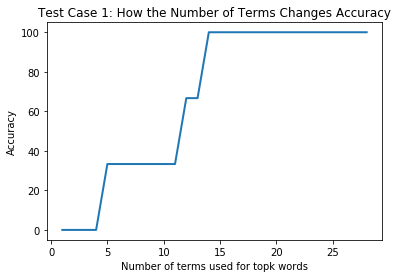

In [35]:
plt.plot(x_data, y_data, linewidth='2.0')
plt.xlabel('Number of terms used for topk words')
plt.ylabel('Accuracy')
plt.title('Test Case 1: How the Number of Terms Changes Accuracy')